# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [6]:
# Блок 1: Импорт библиотек
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [7]:
# Блок 2: Загрузка и предобработка изображения
img_path = 'sar_3.jpg'
source_img = cv2.imread(img_path)

if source_img is None:
    raise FileNotFoundError(f"Файл {img_path} не найден")

gray_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
gray_img_mono = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)

print(f"Размер изображения: {gray_img.shape}")
print(f"Диапазон значений: {gray_img_mono.min()} - {gray_img_mono.max()}")

Размер изображения: (225, 225, 3)
Диапазон значений: 0 - 255


In [8]:
# Блок 3: Поиск линий методом Хафа
smoothed = cv2.GaussianBlur(gray_img_mono, (5, 5), 0)
edges = cv2.Canny(smoothed, 50, 150)

detected_lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)
img_with_lines = gray_img.copy()

if detected_lines is not None:
    max_len = 0
    longest_segment = None

    for rho_val, theta_val in detected_lines[:, 0]:
        cos_t = np.cos(theta_val)
        sin_t = np.sin(theta_val)
        x_center = cos_t * rho_val
        y_center = sin_t * rho_val

        pt_a = (int(x_center + 1000 * (-sin_t)), int(y_center + 1000 * cos_t))
        pt_b = (int(x_center - 1000 * (-sin_t)), int(y_center - 1000 * cos_t))

        segment_length = np.sqrt((pt_a[0] - pt_b[0])**2 + (pt_a[1] - pt_b[1])**2)

        if segment_length > max_len:
            max_len = segment_length
            longest_segment = (pt_a, pt_b)

    if longest_segment:
        cv2.line(img_with_lines, longest_segment[0], longest_segment[1],
                (255, 0, 0), 4, cv2.LINE_AA)
        print(f"Длина найденного сегмента: {max_len:.1f} пикселей")
else:
    print("Линии не обнаружены")

Длина найденного сегмента: 1998.8 пикселей


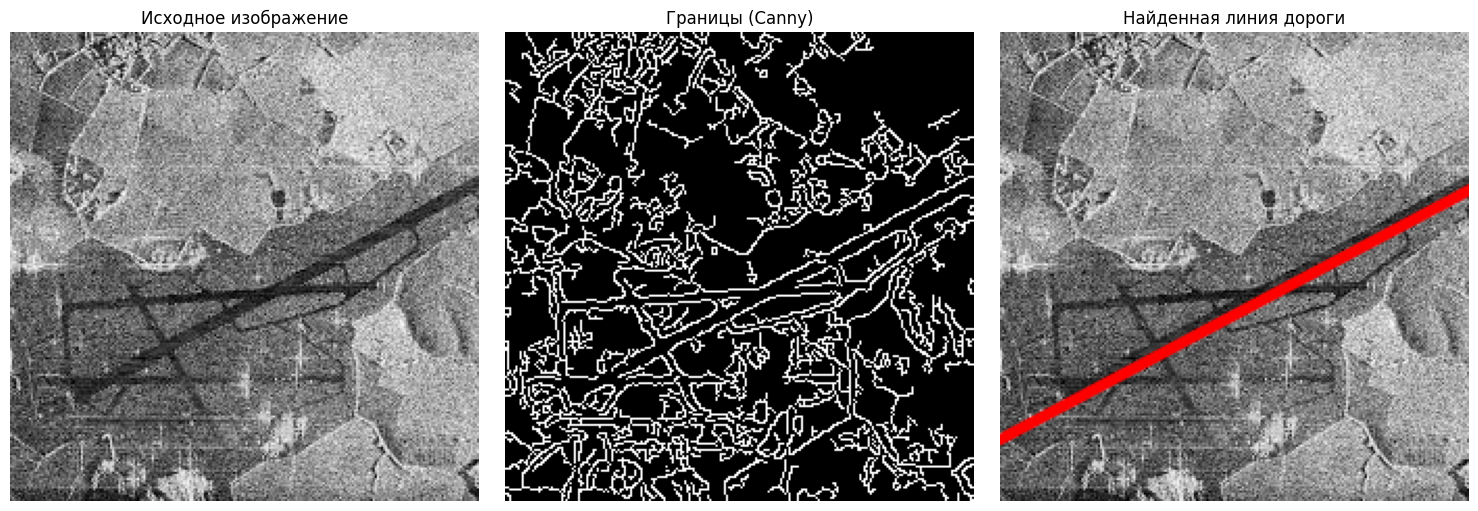

In [9]:
# Блок 4: Визуализация результатов детектирования линий
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(gray_img_mono, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Границы (Canny)')
axes[1].axis('off')

axes[2].imshow(img_with_lines)
axes[2].set_title('Найденная линия дороги')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Блок 5: Методы бинаризации
# Простая пороговая обработка
threshold_value = 50
simple_binary = gray_img_mono.copy()
simple_binary[gray_img_mono < threshold_value] = 0
simple_binary[gray_img_mono >= threshold_value] = 255

# Метод Оцу
_, otsu_binary = cv2.threshold(gray_img_mono, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Адаптивная бинаризация
adaptive_binary = cv2.adaptiveThreshold(gray_img_mono, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 71, 21)

In [11]:
# Блок 6: Оператор Собеля
output_depth = cv2.CV_16S
sobel_x = cv2.Sobel(gray_img_mono, output_depth, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_img_mono, output_depth, 0, 1, ksize=3)
sobel_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

# Нормализация для отображения
sobel_x_norm = cv2.convertScaleAbs(sobel_x)
sobel_y_norm = cv2.convertScaleAbs(sobel_y)
sobel_combined_norm = cv2.convertScaleAbs(sobel_combined)

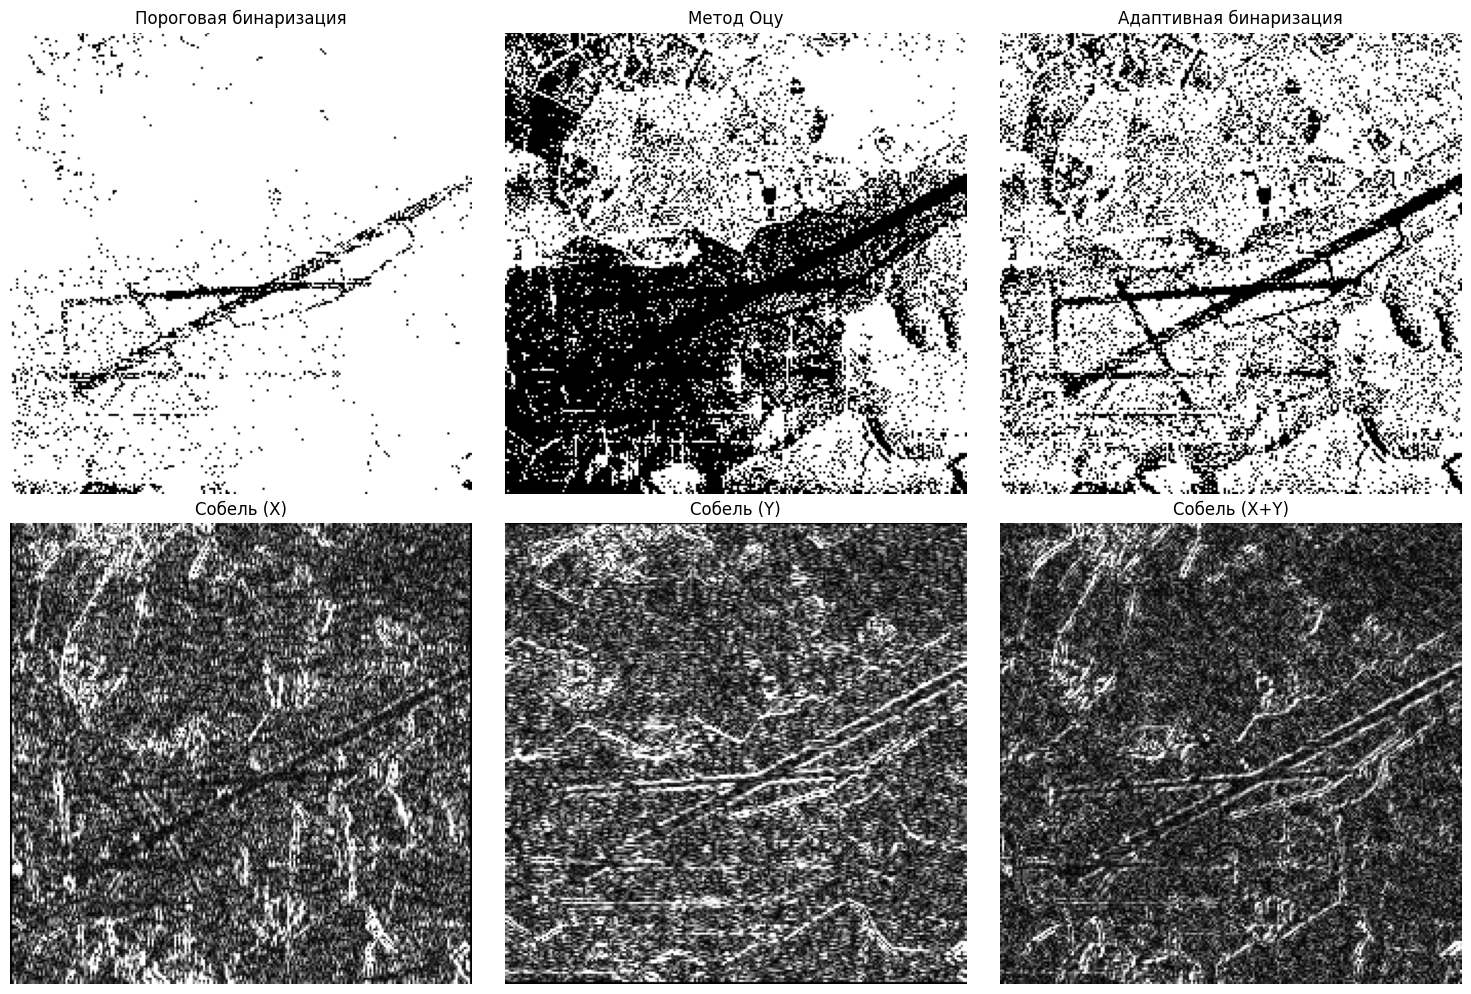

In [12]:
# Блок 7: Визуализация методов бинаризации и оператора Собеля
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Бинаризация
axes[0, 0].imshow(simple_binary, cmap='gray')
axes[0, 0].set_title('Пороговая бинаризация')
axes[0, 0].axis('off')

axes[0, 1].imshow(otsu_binary, cmap='gray')
axes[0, 1].set_title('Метод Оцу')
axes[0, 1].axis('off')

axes[0, 2].imshow(adaptive_binary, cmap='gray')
axes[0, 2].set_title('Адаптивная бинаризация')
axes[0, 2].axis('off')

# Оператор Собеля
axes[1, 0].imshow(sobel_x_norm, cmap='gray')
axes[1, 0].set_title('Собель (X)')
axes[1, 0].axis('off')

axes[1, 1].imshow(sobel_y_norm, cmap='gray')
axes[1, 1].set_title('Собель (Y)')
axes[1, 1].axis('off')

axes[1, 2].imshow(sobel_combined_norm, cmap='gray')
axes[1, 2].set_title('Собель (X+Y)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Блок 8: Сегментация дорожной полосы
preprocessed = cv2.GaussianBlur(simple_binary, (5, 5), 0)
segmented = cv2.adaptiveThreshold(preprocessed, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 55, 2)

contours, hierarchy = cv2.findContours(segmented, cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)

contour_img = gray_img.copy()

if contours:
    significant_contours = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            cv2.drawContours(contour_img, [contour], -1, (255, 0, 0), 2)
            significant_contours += 1
    print(f"Найдено значимых контуров: {significant_contours}")

Найдено значимых контуров: 2


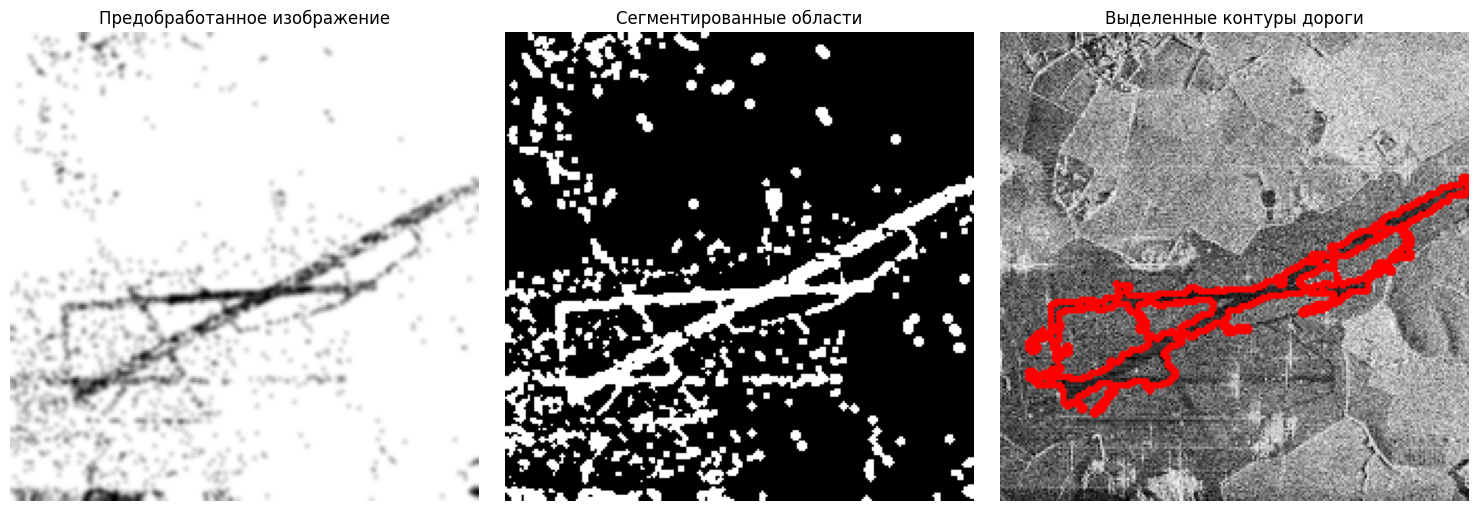

In [14]:
# Блок 9: Визуализация результатов сегментации
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(preprocessed, cmap='gray')
axes[0].set_title('Предобработанное изображение')
axes[0].axis('off')

axes[1].imshow(segmented, cmap='gray')
axes[1].set_title('Сегментированные области')
axes[1].axis('off')

axes[2].imshow(contour_img)
axes[2].set_title('Выделенные контуры дороги')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Блок 10: Сводная информация
print("=== РЕЗУЛЬТАТЫ АНАЛИЗА ===")
print(f"1. Размер изображения: {gray_img.shape[1]}x{gray_img.shape[0]}")
print(f"2. Метод Оцу выбрал порог: {_}")
print(f"3. Найдено линий Хафа: {len(detected_lines) if detected_lines is not None else 0}")
print(f"4. Найдено контуров дороги: {sum(1 for c in contours if cv2.contourArea(c) > 500)}")
print("=" * 30)

=== РЕЗУЛЬТАТЫ АНАЛИЗА ===
1. Размер изображения: 225x225
2. Метод Оцу выбрал порог: 129.0
3. Найдено линий Хафа: 3
4. Найдено контуров дороги: 2
